<h1>Промышленность</h1>

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'> 
    <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
<font color='green'><br>
<br />
Наталья, доброго дня! рад приветствовать тебя в финале) <br />
Вот и он подобрался, поздравляю. Остался последний рывок в этом марафоне)<br>
<br />    
Меня зовут Николай. <br />И на этом этапе Вашего движения к новой профессии от меня будут комментарии по написанному коду. <br />Чтобы меньше "мусорить эфир" и чтобы максимально наглядно отделяться от основного кода, есть предложение условиться в некоторых обозначениях:<br /> <br />
<u><b>ТАКОЙ ШРИФТ</b></u> - всегда начало комментария <br />
<font color='green'>такой шрифт</font> - комментарии о том, что всё ОК <br/>
<font color='purple'>такой шрифт</font> - комментарии о том, что всё ОК по результату,<br> однако что есть ещё что-то или в коде или есть способы сделать более короткий или быстрый код <br/>
<font color='red'>такой шрифт</font> - комментарии о том, что есть критичный момент, влияющий на бизнес-результат проекта.<br/>
</font><br /><br />
<font color='green'>Как и всегда в спринтах - ставлю своей целью максимально помочь. Поэтому, все мои комментарии - это только способ передать свой опыт для помощи в твоих достижениях.

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали.

Вам предстоит построить модель, которая предскажет температуру стали. Изучить характеристики процесса обработки стали. 

Для каждого значения столбца  key найдите:


- Длительность времени между первым и последним замером температуры.
- Суммарное время сообщения электродами, есть сумма значений по всем промежуткам между запусками электродов.
- Количество запусков сообщения электродами.
- Среднее соотношение потребления активной и реактивной мощности.
- По всем полученным столбцам вычислите статистики: средние, минимальные и максимальные значения, медиану и величины 25% - и 75% -квартилей.

<b>Описание данных</b>

Данные состоят из файлов, полученных из разных источников:

- data_arc.csv — данные об электродах;
- data_bulk.csv — данные о подаче сыпучих материалов (объём);
- data_bulk_time.csv — данные о подаче сыпучих материалов (время);
- data_gas.csv — данные о продувке сплава газом;
- data_temp.csv — результаты измерения температуры;
- data_wire.csv — данные о проволочных материалах (объём);
- data_wire_time.csv — данные о проволочных материалах (время).

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

<b>План работы:</b>

1. Подготовка данных для анализа, исключить не заполненные значения.
2. Статистический анализ данных. Анализ заполненных наблюдений
3. Подбор походящей модели и обучение модели, которая предскажет температуру стали.
4. Анализ моделей

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score 
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor 
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor


import time   
import timeit
import warnings
warnings.filterwarnings('ignore')

# Подготовка данных и анализ заполненных наблюдений

<h6>Данные об электродах</h6>

In [2]:
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
display(data_arc.head(5))
data_arc.info()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [3]:
print(data_arc['key'].unique())

data_arc['key'].value_counts()

[   1    2    3 ... 3239 3240 3241]


2108    16
1689    15
1513    15
2567    14
322     13
        ..
614      1
1914     1
2025     1
2795     1
1568     1
Name: key, Length: 3214, dtype: int64

Результат анализа и дальнейшая обработка:

1. Переименовать столбцы для удобства работы в дальнейшем. Преобразовать Даты в тип Datetime

2. 14876 записей, но 1 запись хранила в себе отрицательную "Реактивную мощность". Было решено эту запись удалить.
Итого в датасете "Данные об электродах" хранится 14 875 записей. 

3. Информация об 3241 Key, имеются дублирование key. Т.е по выведеной статистике видно что key 2108 хранит о себе 16 записей информации. Сделаем суммирование активной и реактивной мощности c максимальным значением периода (Начало нагрева дугой и Конец нагрева дугой)


In [4]:
#1
data_arc.columns = ['key', 'start_time','finish_time', 'active_power', 'reactive_power']


data_arc = data_arc.astype({'start_time': 'datetime64[ns]', 'finish_time':'datetime64[ns]'})

In [5]:
#2
data_arc= data_arc[data_arc['reactive_power'] > 0.0]
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14875 entries, 0 to 14875
Data columns (total 5 columns):
key               14875 non-null int64
start_time        14875 non-null datetime64[ns]
finish_time       14875 non-null datetime64[ns]
active_power      14875 non-null float64
reactive_power    14875 non-null float64
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 697.3 KB


<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>с выбросом - понятно. (и удобно придумала - проставлять свой номер блока))

In [6]:
#3
data_prom = data_arc.pivot_table(index='key', values=['active_power','reactive_power']
                                 ,aggfunc=sum)

data_prom

,active_power,reactive_power
key,,
1,4.878147,3.183241
2,3.052598,1.998112
3,2.525882,1.599076
4,3.209250,2.060298
5,3.347173,2.252643
...,...,...
3237,3.932467,2.828459
3238,2.106529,1.681182
3239,4.666754,3.111617


<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА 2</u></b>
</font>
<font color='green'><br>ок

<h6>Данные о подаче сыпучих материалов (объём)</h6>

In [7]:
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')

display(data_bulk.head(5))
data_bulk.info()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [8]:
for i in range(1,16):
    print('Bulk '+str(i)+':', data_bulk['Bulk '+str(i)].unique())

Bulk 1: [ nan  46.  27.  48.  29.  78.  52.  69.  51.  73.  92.  65.  75.  94.
 185.  67.  37.  10.  43.  34.  54.  44.  39.  90.  62.  60.  31.  33.
  50.  83.  58.  41.  38.  30.  63.  19.  21.  47. 118.  28.  36.  22.
  32.  24. 104.  74.  26.  16.]
Bulk 2: [ nan 228. 247. 232. 325. 257. 233. 242. 248. 249. 282. 258. 270. 246.
 254. 236.]
Bulk 3: [ nan  71. 151.  63.  89. 132.  67.  19.  21.  44. 244. 243. 182.  83.
  81. 146. 149.  70.  53. 122. 152. 102.  23.  29.  69.  72. 141.  62.
 349. 261.  92.  80. 123. 213. 305. 249. 171. 300. 262. 114. 198. 202.
 315. 334. 220. 153. 124.  17.  91.  79. 115. 133. 199. 101.  68.  74.
  52.  49. 131.  42. 226. 126.  60.  90.  36. 211. 301. 214. 190. 172.
  59.  87. 246. 121. 116.  99.  93.  57. 177.  55. 119. 134. 165. 139.
  25. 342. 174. 308. 286. 289. 138.  34.  38. 191. 290.  65.  95. 206.
  37. 109.  40. 154. 100. 245. 128.  51. 272. 270. 353. 106. 335. 117.
 197. 120. 137.  66. 144.  46. 193. 155. 248.  26. 239. 189. 298.  97.
 125. 256

Результат анализа и дальнейшая обработка:

1. 3 129 записей о сыпущих материалах (объем). Столбец Bulk 8 исключим из данных, т.к он практически никакой информации не содержит

В конце обработки всех данных, после обьединения в общий датасет необходимо:
1. Записи с nan, были заменены на 0.0. 
2. После того как вывели список уникальных значений в столбцах Bulk, было замечано что все значения типа int. Необходим перевод

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА </u></b>
</font>
<font color='green'><br>ок, на 0.

In [9]:
data_bulk= data_bulk.drop('Bulk 8', axis=1)

data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 15 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(14), int64(1)
memory usage: 366.8 KB


<h6>Данные о подаче сыпучих материалов (время)</h6>

In [10]:
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')

display(data_bulk_time.head(5))
data_bulk_time.info()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null object
Bulk 2     22 non-null object
Bulk 3     1298 non-null object
Bulk 4     1014 non-null object
Bulk 5     77 non-null object
Bulk 6     576 non-null object
Bulk 7     25 non-null object
Bulk 8     1 non-null object
Bulk 9     19 non-null object
Bulk 10    176 non-null object
Bulk 11    177 non-null object
Bulk 12    2450 non-null object
Bulk 13    18 non-null object
Bulk 14    2806 non-null object
Bulk 15    2248 non-null object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


Результат анализа и дальнейшая обработка:

Датасет хранит даты, для обучения модели не используем. Пропускаем

<h6>Данные о продувке сплава газом</h6>

In [11]:
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')

display(data_gas.head(5))
data_gas.info()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [12]:
print(data_gas['key'].unique())

data_gas['key'].value_counts()

[   1    2    3 ... 3239 3240 3241]


2047    1
2580    1
2600    1
549     1
2596    1
       ..
3119    1
1070    1
3115    1
1066    1
2049    1
Name: key, Length: 3239, dtype: int64

Результат анализа и дальнейшая обработка:

1. Переименовать столбцы.
2. 3239 записей, датасет  c заполненными данные, key уникальны.
3. Обьединить таблицы "Данные об электродах", которые просуммированые по мощностям и "Данные о продувке сплава газом". После обьединения провести проверку все ли key имеют данные о продувке газов, в случае пропусков заполнить нулями

In [13]:
#1
data_gas.columns = ['key','gas_1']

In [14]:
#3
data_prom = data_prom.merge(data_gas, on='key')
data_prom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3212 entries, 0 to 3211
Data columns (total 4 columns):
key               3212 non-null int64
active_power      3212 non-null float64
reactive_power    3212 non-null float64
gas_1             3212 non-null float64
dtypes: float64(3), int64(1)
memory usage: 125.5 KB


<h6>Результаты измерения температуры</h6>

In [15]:
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')

display(data_temp.head(5))
data_temp.info()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null object
Температура     13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [16]:
print(data_temp['key'].unique())

print(data_temp['key'].value_counts())

data_temp['Температура'].unique()

[   1    2    3 ... 3239 3240 3241]
44      16
1214    16
1513    16
46      16
1689    15
        ..
1106     2
1424     2
3156     2
279      1
195      1
Name: key, Length: 3216, dtype: int64


array([1571., 1604., 1618., 1601., 1613., 1581., 1577., 1589., 1608.,
       1602., 1596., 1597., 1598., 1599., 1623., 1625., 1576., 1543.,
       1600., 1586., 1582., 1595., 1587., 1592., 1574., 1580., 1585.,
       1588., 1593., 1616., 1583., 1606., 1584., 1591., 1610., 1621.,
       1615., 1619., 1605., 1607., 1611., 1590., 1609., 1603., 1579.,
       1626., 1617., 1560., 1563., 1594., 1612., 1578., 1566., 1572.,
       1575., 1614., 1567., 1562., 1564., 1636., 1570., 1538., 1556.,
       1629., 1542., 1565., 1573., 1660., 1690., 1652., 1666., 1667.,
       1669., 1668., 1642., 1658., 1671., 1665., 1674., 1676., 1630.,
       1654., 1655., 1663., 1635., 1656., 1631., 1653., 1648., 1659.,
       1641., 1645., 1675., 1569., 1559., 1558., 1548., 1541., 1553.,
       1662., 1679., 1637., 1622., 1644., 1649., 1643., 1526., 1550.,
       1561., 1557., 1544., 1568., 1620., 1647., 1638., 1547., 1627.,
       1628., 1551., 1549., 1624., 1650., 1684., 1634., 1646., 1651.,
       1633., 1640.,

Результат анализа и дальнейшая обработка:

1. Переименовать столбцы датасета, поменять тип столбца "Время замера" на datetime, Температура на int
2. Удалить записи где:
- не отмечан температурный режим 
- только одна запись измерения температуры
- дата замера записана раньше чем даты окончального нагрева дугою (finish_date) из датасета "Данные об электродах"

3. Собирём новый датасет "Результаты измерения температуры"

key / минимальная температура / максимальное температура

4. Обьединить датасеты "Данные об электродах", которые просуммированые по мощностями и "Результаты измерения температуры" максимальными и минимальными температурами измерения. После обьединения провести проверку обьединения

In [17]:
#1
data_temp.columns = ['key','time_zamera','temperature']
data_temp = data_temp.astype({'time_zamera': 'datetime64[ns]'})

In [18]:
#2
data_temp = data_temp.dropna()
data_temp = data_temp.astype({'temperature': 'int'})

data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13006 entries, 0 to 15902
Data columns (total 3 columns):
key            13006 non-null int64
time_zamera    13006 non-null datetime64[ns]
temperature    13006 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 406.4 KB


In [19]:
#2
key_list = []

for k in list(data_temp['key'].unique()):
    if (data_temp[data_temp['key'] == k]['key'].count() == 1) or (data_temp[data_temp['key'] == k]['time_zamera'].max() < data_arc[data_arc['key'] == k]['finish_time'].max()):
        key_list.append(k)

data_temp = data_temp.query("key not in @key_list")
data_temp.info()   

data_temp

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11680 entries, 0 to 12266
Data columns (total 3 columns):
key            11680 non-null int64
time_zamera    11680 non-null datetime64[ns]
temperature    11680 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 365.0 KB


,key,time_zamera,temperature
0,1,2019-05-03 11:16:18,1571
1,1,2019-05-03 11:25:53,1604
2,1,2019-05-03 11:29:11,1618
3,1,2019-05-03 11:30:01,1601
4,1,2019-05-03 11:30:39,1613
...,...,...,...
12262,2498,2019-08-06 02:19:26,1593
12263,2498,2019-08-06 02:25:31,1594
12264,2499,2019-08-06 02:40:25,1569
12265,2499,2019-08-06 02:54:24,1604


In [20]:
#3
data_temp1 = pd.DataFrame(data = data_temp['key'].unique(), columns = ["key"])
list1 = []
for i,r in data_temp1.iterrows():
    a = r["key"]
    temp = data_temp.query('key == @a')
    str1 = temp[temp['time_zamera']==temp['time_zamera'].max()]
    str2 = temp[temp['time_zamera']==temp['time_zamera'].min()]
    min2 = str2['temperature'].values[0].astype(int)
    max1 = str1['temperature'].values[0].astype(int)
    list1.append([a, min2, max1])

data_temp1 = pd.DataFrame(list1, columns = ['key', 'temp_min', 'temp_max'])
display(data_temp1.head(5))

,key,temp_min,temp_max
0,1,1571,1613
1,2,1581,1602
2,3,1596,1599
3,4,1601,1625
4,5,1576,1602


In [21]:
#4
data_prom = data_prom.merge(data_temp1, on='key')
#data_prom = data_prom[['key','active_power','reactive_power','gas_1', 'measurement_max','measurement_min','temperature']]

data_prom.info()
display(data_prom)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2342 entries, 0 to 2341
Data columns (total 6 columns):
key               2342 non-null int64
active_power      2342 non-null float64
reactive_power    2342 non-null float64
gas_1             2342 non-null float64
temp_min          2342 non-null int64
temp_max          2342 non-null int64
dtypes: float64(3), int64(3)
memory usage: 128.1 KB


,key,active_power,reactive_power,gas_1,temp_min,temp_max
0,1,4.878147,3.183241,29.749986,1571,1613
1,2,3.052598,1.998112,12.555561,1581,1602
2,3,2.525882,1.599076,28.554793,1596,1599
3,4,3.209250,2.060298,18.841219,1601,1625
4,5,3.347173,2.252643,5.413692,1576,1602
...,...,...,...,...,...,...
2337,2495,3.210690,2.360777,7.125735,1570,1591
2338,2496,4.203064,2.810185,9.412616,1554,1591
2339,2497,2.212379,1.851269,6.271699,1571,1589
2340,2498,3.408725,2.355428,14.953657,1591,1594


<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА </u></b>
</font>
<font color='green'><br>да!!! это важный момент проект - отсечь лишние столбцы. И ты сделал это верно)

<h6>Данные о проволочных материалах (объём)</h6>

In [22]:
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')

display(data_wire.head(5))
data_wire.info()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Результат анализа и дальнейшая обработка:

3 081 записей о проволочных материалах (объём). 
1. Удалить столбец Wire 5, т.к столбец не содержит никакой информации

В конце обработки всех данных, после обьединения в общий датасет необходимо:
1. Записи с nan, были заменены на 0.0. 
2. Перевод тип данных float столбцы Wire.

In [23]:
data_wire= data_wire.drop('Wire 5', axis=1)

data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 9 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(8), int64(1)
memory usage: 216.8 KB


<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>тут понятно)

<h6>Данные о проволочных материалах (время)</h6>

In [24]:
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

display(data_wire_time.head(5))
data_wire_time.info()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null object
Wire 2    1079 non-null object
Wire 3    63 non-null object
Wire 4    14 non-null object
Wire 5    1 non-null object
Wire 6    73 non-null object
Wire 7    11 non-null object
Wire 8    19 non-null object
Wire 9    29 non-null object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


Результат анализа и дальнейшая обработка:

Датасет хранит даты, для обучения модели не используем. Пропускаем

<h6>Обьединение, сборка датасета</h6>

In [25]:
data_prom = data_prom.merge(data_bulk, on='key')
data_prom = data_prom.merge(data_wire, on='key')

data_prom.info()
display(data_prom.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2210 entries, 0 to 2209
Data columns (total 28 columns):
key               2210 non-null int64
active_power      2210 non-null float64
reactive_power    2210 non-null float64
gas_1             2210 non-null float64
temp_min          2210 non-null int64
temp_max          2210 non-null int64
Bulk 1            189 non-null float64
Bulk 2            13 non-null float64
Bulk 3            926 non-null float64
Bulk 4            756 non-null float64
Bulk 5            53 non-null float64
Bulk 6            428 non-null float64
Bulk 7            13 non-null float64
Bulk 9            13 non-null float64
Bulk 10           130 non-null float64
Bulk 11           124 non-null float64
Bulk 12           1730 non-null float64
Bulk 13           13 non-null float64
Bulk 14           1977 non-null float64
Bulk 15           1619 non-null float64
Wire 1            2188 non-null float64
Wire 2            777 non-null float64
Wire 3            39 non-null float6

,key,active_power,reactive_power,gas_1,temp_min,temp_max,Bulk 1,Bulk 2,Bulk 3,Bulk 4,...,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
0,1,4.878147,3.183241,29.749986,1571,1613,NaN,NaN,NaN,43.0,...,150.0,154.0,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,3.052598,1.998112,12.555561,1581,1602,NaN,NaN,NaN,73.0,...,149.0,154.0,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2.525882,1.599076,28.554793,1596,1599,NaN,NaN,NaN,34.0,...,152.0,153.0,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,3.209250,2.060298,18.841219,1601,1625,NaN,NaN,NaN,81.0,...,153.0,154.0,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,3.347173,2.252643,5.413692,1576,1602,NaN,NaN,NaN,78.0,...,151.0,152.0,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
print('=============================')
print('Кол-во пропусков')
report = data_prom.isna().sum().to_frame()
report = report.rename(columns = {0: 'missing_values'})
report['% of total'] = (report['missing_values'] / data_prom.shape[0]).round(2)
report.sort_values(by = 'missing_values', ascending = False)

Кол-во пропусков


,missing_values,% of total
Wire 7,2206,1.00
Wire 4,2198,0.99
Bulk 7,2197,0.99
Wire 8,2197,0.99
Bulk 2,2197,0.99
Bulk 13,2197,0.99
Bulk 9,2197,0.99
Wire 9,2188,0.99
Wire 3,2171,0.98
Wire 6,2165,0.98


Датасет для проведения обучения собран, но требуется еще обработка:

1. удалить столбец Wire 7, практически не содержит информации
2. Записи с nan, были заменены на 0.0.

In [27]:
#1
data_prom= data_prom.drop('Wire 7', axis=1)

#2
for i in range(1,16):
    if i !=8:
        data_prom['Bulk '+str(i)] = data_prom['Bulk '+str(i)].fillna(0.0)

for i in range(1,10):
    if i not in (5,7):
        data_prom['Wire '+str(i)] = data_prom['Wire '+str(i)].fillna('0.0')

data_prom = data_prom.astype({'Wire 1': float,'Wire 2': float,'Wire 3': float,'Wire 4': float,'Wire 6': float,'Wire 8': float,'Wire 9': float})

data_prom.columns = map(str.lower, data_prom.columns)
data_prom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2210 entries, 0 to 2209
Data columns (total 27 columns):
key               2210 non-null int64
active_power      2210 non-null float64
reactive_power    2210 non-null float64
gas_1             2210 non-null float64
temp_min          2210 non-null int64
temp_max          2210 non-null int64
bulk 1            2210 non-null float64
bulk 2            2210 non-null float64
bulk 3            2210 non-null float64
bulk 4            2210 non-null float64
bulk 5            2210 non-null float64
bulk 6            2210 non-null float64
bulk 7            2210 non-null float64
bulk 9            2210 non-null float64
bulk 10           2210 non-null float64
bulk 11           2210 non-null float64
bulk 12           2210 non-null float64
bulk 13           2210 non-null float64
bulk 14           2210 non-null float64
bulk 15           2210 non-null float64
wire 1            2210 non-null float64
wire 2            2210 non-null float64
wire 3            2

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>хорошая работа по разделу)

# Статистический анализ данных

Распределение мощности

In [28]:
data = data_prom[['key','active_power','reactive_power']]
data['active_power'] = data['active_power'].astype(float)
data['reactive_power'] = data['reactive_power'].astype(float)

for i, r in data.iterrows():
    data.loc[i, 'power']= math.sqrt(pow(r['active_power'], 2)+ pow(r['reactive_power'], 2))

display(data)

,key,active_power,reactive_power,power
0,1,4.878147,3.183241,5.824889
1,2,3.052598,1.998112,3.648398
2,3,2.525882,1.599076,2.989502
3,4,3.209250,2.060298,3.813674
4,5,3.347173,2.252643,4.034596
...,...,...,...,...
2205,2495,3.210690,2.360777,3.985197
2206,2496,4.203064,2.810185,5.055976
2207,2497,2.212379,1.851269,2.884756
2208,2498,3.408725,2.355428,4.143362


In [29]:
data.describe()

,key,active_power,reactive_power,power
count,2210.000000,2210.000000,2210.000000,2210.000000
mean,1255.730317,3.152488,2.346247,3.935486
std,712.514959,1.428084,1.083998,1.780297
min,1.000000,0.186226,0.158247,0.257637
25%,644.250000,2.166351,1.623431,2.719373
50%,1256.500000,3.036472,2.233867,3.774646
75%,1866.750000,3.920817,2.914284,4.878879
max,2499.000000,17.496497,12.587990,21.554231


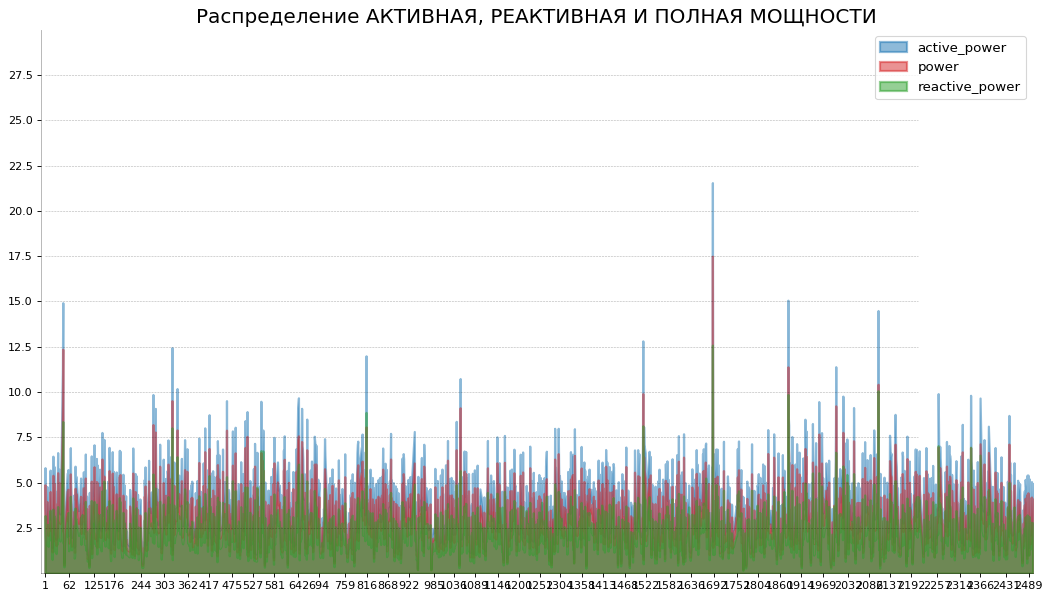

In [30]:
x = data['key'].values.tolist()
y1 = data['power'].values.tolist()
y2 = data['active_power'].values.tolist()
y3 = data['reactive_power'].values.tolist()
mycolors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:brown', 'tab:grey', 'tab:pink', 'tab:olive']      
columns = ['power', 'active_power','reactive_power']

fig, ax = plt.subplots(1, 1, figsize=(16,9), dpi= 80)
ax.fill_between(x, y1=y1, y2=0, label=columns[1], alpha=0.5, color=mycolors[1], linewidth=2)
ax.fill_between(x, y1=y2, y2=0, label=columns[0], alpha=0.5, color=mycolors[0], linewidth=2)
ax.fill_between(x, y1=y3, y2=0, label=columns[2], alpha=0.5, color=mycolors[2], linewidth=2)

ax.set_title('Распределение АКТИВНАЯ, РЕАКТИВНАЯ И ПОЛНАЯ МОЩНОСТИ', fontsize=18)
ax.set(ylim=[0, 30])
ax.legend(loc='best', fontsize=12)
plt.xticks(x[::50], fontsize=10, horizontalalignment='center')
plt.yticks(np.arange(2.5, 30.0, 2.5), fontsize=10)
plt.xlim(-10, x[-1])

# Draw Tick lines  
for y in np.arange(2.5, 30.0, 2.5):    
    plt.hlines(y, xmin=0, xmax=len(x), colors='black', alpha=0.3, linestyles="--", lw=0.5)

# Lighten borders
plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(.3)
plt.show()

<b>Вывод:</b>

Вывела отдельный датасет и сделала расчет полной мощности для каждого key позиции.
Формула расчета:

Реактивная мощноть = √ (Полная мощность2 – Активная мощность2)

Наглядный результат показателей отображон на графике.

На графике показано распределение мощностей всех 2 210 key

- полная мощность(power) сотоит из комбинации реактивной и активной мощностей, распределена в средней части графика. Хотя судя по описательную статистике максимальное значение выше всех видов мощностей, равна 21.554. , минимальное значение 0.2576

- Активная мощность, которая является полезной, реальной мощностью показывает результаты на верхнем уровне.

- Реактивная, бесполезной или безваттной мощность находится в правильном нижнем уровне распредедения показателей.

{'whiskers': [<matplotlib.lines.Line2D at 0x7f90693a7450>,
 'caps': [<matplotlib.lines.Line2D at 0x7f90693a7e10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9060fb9790>,
 'medians': [<matplotlib.lines.Line2D at 0x7f90693b08d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f90693b0d90>,
 'means': []}

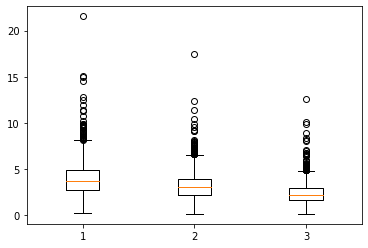

In [31]:
x1 = data['power'] 
x2 = data['active_power'] 
x3 = data['reactive_power'] 

plt.boxplot ([x1, x2, x3])

<b>Вывод:</b>

На графике также отображается три вида мощности. 

- Медиана проходит в середине всех трех ящиков

power- 3.935486

active_power- 3.152488	

reactive_power- 2.346247

- нижний квартиль

power- 2.719373 

active_power- 2.166351	

reactive_power- 1.623431

- верхний квартиль 

power-4.878879

active_power-3.920817

reactive_power-2.914284	


Выбросы в большом кол-ве. Отбрасывать мы не будем, т.е для обучения модели будем использовать все показатели

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>
хорошо. С выбросами тут действительно важный момент. Ведь выброс выбросу рознь) Бывает, что выброс - то реальная бизнес-практика. И если удалить их, то мы получим модель, так скажем, работующую не во всех диапазонах входящих в неё факторов. Т.е. по метрикам модель будет хорошая. А вот по бизнесу - не совсем применимая.<br>А бывают выбросы - точно выбросы - ошибки учёта данных, например.<br>
    
В самой теории выбросов принято считать, что выбросы в интервале от q_3 + 1.5*irq до q_3 + з*irq - на усмотрение бизнеса. А вот всё, что больше q_3 + 3*irq - уже точно надо работать - на удаление!!!<br>
q_3 - верхняя квартиль<br>
irq - интерквартильный размах

В таких проектах, также лучше использовать такую философию анализа выбросов:<br>
Ящик с усами - даёт пищу для размышлений (не более того, не воспринимаем его как сигнал к действию).<br>
А потом смотрим то явление, что изучаем. Данные значения - могут быть в реальности или нет?<br>
Вот, например, в случае с температурой плавления: по справочнику она у металла = около 1400+-, т.е. 1200 - действиетльно кажется очень странным значением. 

# Обучение модели

Данные были подготовлены для обучения к модели. 

- Целевым признаком является столбец temp_max (температура последнего времени замера у электрода).

Набор признаков для предсказания получим с помощью вычисления попарной корреляцию столбцов.  Используем абсолютное числовое значение больше 10%


In [32]:
data_prom.corr()['temp_max'].abs() >= 0.1

key               False
active_power       True
reactive_power     True
gas_1             False
temp_min           True
temp_max           True
bulk 1            False
bulk 2            False
bulk 3            False
bulk 4             True
bulk 5            False
bulk 6             True
bulk 7             True
bulk 9            False
bulk 10           False
bulk 11            True
bulk 12            True
bulk 13           False
bulk 14            True
bulk 15            True
wire 1             True
wire 2             True
wire 3            False
wire 4             True
wire 6            False
wire 8            False
wire 9            False
Name: temp_max, dtype: bool

In [33]:
data_prom = data_prom[['active_power','reactive_power', 'temp_min', 
                       'temp_max','bulk 4','bulk 6','bulk 7','bulk 11','bulk 12','bulk 14',
                      'bulk 15','wire 1','wire 2','wire 4']]

In [34]:
data_prom.corr().abs() > 0.8

,active_power,reactive_power,temp_min,temp_max,bulk 4,bulk 6,bulk 7,bulk 11,bulk 12,bulk 14,bulk 15,wire 1,wire 2,wire 4
active_power,True,True,False,False,False,False,False,False,False,False,False,False,False,False
reactive_power,True,True,False,False,False,False,False,False,False,False,False,False,False,False
temp_min,False,False,True,False,False,False,False,False,False,False,False,False,False,False
temp_max,False,False,False,True,False,False,False,False,False,False,False,False,False,False
bulk 4,False,False,False,False,True,False,False,False,False,False,False,False,False,False
bulk 6,False,False,False,False,False,True,False,False,False,False,False,False,False,False
bulk 7,False,False,False,False,False,False,True,False,False,False,False,False,False,False
bulk 11,False,False,False,False,False,False,False,True,False,False,False,False,False,False
bulk 12,False,False,False,False,False,False,False,False,True,False,False,False,False,False
bulk 14,False,False,False,False,False,False,False,False,False,True,False,False,False,False


<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> 
    
    1. Оценку мультиколлинеарности и определение зависимостей между целевым признаком и остальными.
    
По результатам видим что есть зависимость признаков active_power и reactive_power. 
Тогда получается надо перед обучением моделями выполнить одно из решений на выбор:
1. Увеличить размер выборки. Больше данных могут дать более точные оценки параметров с меньшими стандартными ошибками.
2. Удалить из выборки одну из проблемных переменных.
3. Либо просуммировать значения проблемных переменным и записать в одну  из переменную

Выполню 2 вариант

С целевым признаков temp_max проблем не наблюдается
</div>


In [35]:
data_prom = data_prom[['active_power', 'temp_min', 'temp_max','bulk 4','bulk 6','bulk 7','bulk 11','bulk 12','bulk 14',
                       'bulk 15','wire 1','wire 2','wire 4']]

In [36]:
cv = 5
random_state=12345


features = data_prom.drop('temp_max', axis=1)
target = data_prom['temp_max']

features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            test_size=0.25, random_state=random_state)

,value
active_power,0.161267
temp_min,0.140782
temp_max,0.066233
bulk 4,0.037185
bulk 6,0.002440
bulk 7,0.014278
bulk 11,0.106371
bulk 12,0.129208
bulk 14,0.106839
bulk 15,0.155800


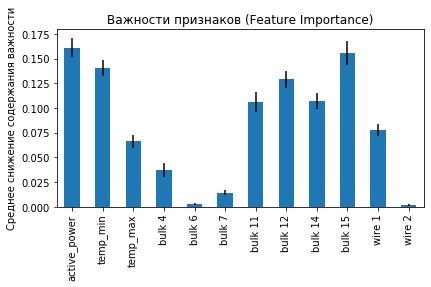

In [37]:
features, target = make_classification(n_samples=1000, n_features=13, n_informative=3, n_redundant=0,
                                       n_repeated=0, n_classes=2, random_state=0, shuffle=False)

feature_names = [f'{i}' for i in data_prom.columns[0:12]]
forest = RandomForestClassifier(random_state=0)
forest.fit(features_train, target_train)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

forest_importances = pd.DataFrame(importances, index=feature_names, columns=['value'])
display(forest_importances)


fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Важности признаков (Feature Importance)")
ax.set_ylabel("Среднее снижение содержания важности")
ax.legend().set_visible(False)
fig.tight_layout()

<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> 
    
    2. feature_importances_
    
1. Провела расчет важности признаков с помощью перемешивания значений, использовала библиотеку learn.ensemble.RandomForestClassifier 

    Проверка показала что: bulk 6 и wire 2 хранят меньше всего важной информации для обучения модели. 
2. Отобразила для наглядности признаки на графике

Было решено bulk 6 и wire 2 убрать из набора признаков.

3. Далее собрать новый набор признаков, новое разделение на обучающую и тестовую наборов данных
</div>


Набор спизнаков для обучения:
    
- active_power
- temp_min
- temp_max           
- bulk 4
- bulk 7
- bulk 11
- bulk 12
- bulk 14
- bulk 15
- wire 1
- wire 4

Набор данных разделим на train и test к соотношению 75/25

In [38]:
data_prom = data_prom[['active_power', 'temp_min', 'temp_max','bulk 4','bulk 7','bulk 11','bulk 12','bulk 14',
                       'bulk 15','wire 1','wire 4']]

In [39]:
features = data_prom.drop('temp_max', axis=1)
target = data_prom['temp_max']

features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            test_size=0.25, random_state=random_state)

<b> LinearRegression</b>

In [40]:
%%time
start_time = time.time()

model_LR = LinearRegression()
 
MAE_LR = (cross_val_score(model_LR,features_train, target_train,cv=cv, scoring='neg_mean_absolute_error').mean() * -1)

stop_time = time.time()
time_LR = round(stop_time - start_time,3)
print('MAE LinearRegression- ', MAE_LR, ', time ', time_LR)

MAE LinearRegression-  6.7854647478040775 , time  0.037
CPU times: user 32.1 ms, sys: 12.3 ms, total: 44.4 ms
Wall time: 37.2 ms


<b>Регрессия DecisionTreeRegressor</b>

In [41]:
%%time

start_time = time.time()
model_DTR = DecisionTreeRegressor() 
max_depth_list = [x for x in range(1, 31)]
hyperparams = [{'criterion':['mse'], 'max_depth':max_depth_list, 'random_state':[random_state]}]

 
clf = GridSearchCV(model_DTR, hyperparams, cv=cv, scoring='neg_mean_absolute_error')
clf.fit(features_train, target_train)
print(clf.best_params_)
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1), params))
print()
MAE_DTR = (max(means)*-1)

stop_time = time.time()
time_DTR = round(stop_time - start_time,3)
print('MAE DecisionTreeRegressor- ', MAE_DTR, ', time ', time_DTR)

{'criterion': 'mse', 'max_depth': 5, 'random_state': 12345}
8.070727 for {'criterion': 'mse', 'max_depth': 1, 'random_state': 12345}
7.681995 for {'criterion': 'mse', 'max_depth': 2, 'random_state': 12345}
7.446861 for {'criterion': 'mse', 'max_depth': 3, 'random_state': 12345}
7.190392 for {'criterion': 'mse', 'max_depth': 4, 'random_state': 12345}
6.934556 for {'criterion': 'mse', 'max_depth': 5, 'random_state': 12345}
7.109161 for {'criterion': 'mse', 'max_depth': 6, 'random_state': 12345}
7.213006 for {'criterion': 'mse', 'max_depth': 7, 'random_state': 12345}
7.357303 for {'criterion': 'mse', 'max_depth': 8, 'random_state': 12345}
7.697563 for {'criterion': 'mse', 'max_depth': 9, 'random_state': 12345}
7.820833 for {'criterion': 'mse', 'max_depth': 10, 'random_state': 12345}
8.183956 for {'criterion': 'mse', 'max_depth': 11, 'random_state': 12345}
8.457168 for {'criterion': 'mse', 'max_depth': 12, 'random_state': 12345}
8.647385 for {'criterion': 'mse', 'max_depth': 13, 'random_st

<b>CatBoostRegressor</b>

In [42]:
%%time

start_time = time.time()
model_CBR = CatBoostRegressor() 
hyperparams = [{'learning_rate':[0.1, 0.5, 0.8], 'random_state':[random_state], 'verbose':[False]}]

clf = GridSearchCV(model_CBR, hyperparams, cv=cv, scoring='neg_mean_absolute_error')
clf.fit(features_train, target_train)
print(clf.best_params_)
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1), params))
print()

MAE_CBR = (max(means)*-1)
stop_time = time.time()
time_CBR = round(stop_time - start_time,3)
print('MAE CatBoostRegressor- ', MAE_CBR, ', time ', time_CBR)

{'learning_rate': 0.1, 'random_state': 12345, 'verbose': False}
6.686946 for {'learning_rate': 0.1, 'random_state': 12345, 'verbose': False}
7.115333 for {'learning_rate': 0.5, 'random_state': 12345, 'verbose': False}
7.401671 for {'learning_rate': 0.8, 'random_state': 12345, 'verbose': False}

MAE CatBoostRegressor-  6.686946483813975 , time  166.032
CPU times: user 2min 10s, sys: 16.1 s, total: 2min 26s
Wall time: 2min 46s


<b>Регрессия LGBMRegressor</b>

In [43]:
%%time

start_time = time.time()
model_LGBM = LGBMRegressor() 
hyperparams = [{'num_leaves':[31, 100, 200], 'learning_rate':[0.1, 0.3, 0.5], 'random_state':[random_state]}]

clf = GridSearchCV(model_LGBM, hyperparams, cv=5, scoring='neg_mean_absolute_error')
clf.fit(features_train, target_train)
print(clf.best_params_)
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1), params))
print()

MAE_LGBM = (max(means)*-1)
stop_time = time.time()
time_LGBM = round(stop_time - start_time,3)
print('MAE LGBMRegressor- ', MAE_LGBM, ', time ', time_LGBM)

{'learning_rate': 0.1, 'num_leaves': 31, 'random_state': 12345}
6.550076 for {'learning_rate': 0.1, 'num_leaves': 31, 'random_state': 12345}
6.643669 for {'learning_rate': 0.1, 'num_leaves': 100, 'random_state': 12345}
6.643669 for {'learning_rate': 0.1, 'num_leaves': 200, 'random_state': 12345}
6.962952 for {'learning_rate': 0.3, 'num_leaves': 31, 'random_state': 12345}
7.010350 for {'learning_rate': 0.3, 'num_leaves': 100, 'random_state': 12345}
7.010350 for {'learning_rate': 0.3, 'num_leaves': 200, 'random_state': 12345}
7.453690 for {'learning_rate': 0.5, 'num_leaves': 31, 'random_state': 12345}
7.363727 for {'learning_rate': 0.5, 'num_leaves': 100, 'random_state': 12345}
7.363727 for {'learning_rate': 0.5, 'num_leaves': 200, 'random_state': 12345}

MAE LGBMRegressor-  6.550076302586018 , time  54.785
CPU times: user 53.9 s, sys: 154 ms, total: 54 s
Wall time: 54.8 s


<b>Вывод:</b>
Получилось зафиксировать лучшие параметры обучения. Впереди проверка на тестовой выборке с лучшими гиперпараметрами

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>
модельная охота - удалась, на мой взгляд.

# Анализ моделей

In [44]:
%%time
start_time = time.time()

model = LinearRegression()
model.fit(features_train, target_train)
predict = model.predict(features_test)
test_MAE_LR = mean_absolute_error(predict, target_test)

stop_time = time.time()
time_LR_test = round(stop_time - start_time,3)
print('MAE LinearRegression -', test_MAE_LR, ', time ', time_LR_test)

MAE LinearRegression - 6.827319349898477 , time  0.004
CPU times: user 3.55 ms, sys: 3.59 ms, total: 7.14 ms
Wall time: 4.51 ms


In [45]:
%%time
start_time = time.time()

model = DecisionTreeRegressor(criterion='mse', max_depth=5,  random_state=random_state) 
model.fit(features_train, target_train)
predict = model.predict(features_test)
test_MAE_DTR = mean_absolute_error(predict, target_test)

stop_time = time.time()
time_DTR_test= round(stop_time - start_time,3)
print('MAE DecisionTreeRegressor ', test_MAE_DTR, ', time ', time_DTR_test)

MAE DecisionTreeRegressor  6.965490955610516 , time  0.006
CPU times: user 10.6 ms, sys: 8.23 ms, total: 18.9 ms
Wall time: 6.13 ms


In [46]:
%%time
start_time = time.time()

model = CatBoostRegressor(learning_rate=0.1, random_state=random_state, verbose=False) 
model.fit(features_train, target_train)
predict = model.predict(features_test)
test_MAE_CBR =  mean_absolute_error(predict, target_test)

stop_time = time.time()
time_CBR_test= round(stop_time - start_time,3)
print('MAE CatBoostRegressor ', test_MAE_CBR, ', time ', time_CBR_test)

MAE CatBoostRegressor  6.433386353982374 , time  11.018
CPU times: user 8.86 s, sys: 960 ms, total: 9.82 s
Wall time: 11 s


In [47]:
%%time
start_time = time.time()

model = LGBMRegressor(learning_rate=0.1, num_leaves=31, random_state=random_state)
model.fit(features_train, target_train)
predict = model.predict(features_test)
test_MAE_LGBMR = mean_absolute_error(predict, target_test)

stop_time = time.time()
time_LGBM_test= round(stop_time - start_time,3)
print('MAE LGBMRegressor ', test_MAE_LGBMR, ', time ', time_LGBM_test)

MAE LGBMRegressor  6.456540091434504 , time  0.963
CPU times: user 988 ms, sys: 0 ns, total: 988 ms
Wall time: 964 ms


<b>Рейтинг моделей</b>

In [48]:
index = ['LinearRegression', 'DecisionTreeRegressor', 'CatBoostRegressor', 'LGBMRegressor']

data = {'MAE на обучающей выборке':[MAE_LR, MAE_DTR, MAE_CBR, MAE_LGBM],
        'Время подбора гиперпараметров, сек':[time_LR, time_DTR, time_CBR, time_LGBM],
        'MAE на тестовой выборке':[test_MAE_LR, test_MAE_DTR, test_MAE_CBR, test_MAE_LGBMR],
        'Время предсказания модели, сек':[time_LR_test, time_DTR_test, time_CBR_test, time_LGBM_test]}

stat = pd.DataFrame(data=data, index=index)

for i, r in stat.iterrows():
    stat.loc[i,'Рейтинг MAE'] = stat['MAE на обучающей выборке'].min()/r['MAE на обучающей выборке']
    stat.loc[i,'Рейтинг времени предсказания'] = stat['Время предсказания модели, сек'].min() / r['Время предсказания модели, сек']
    stat.loc[i,'Итоговый рейтинг'] = stat.loc[i,'Рейтинг MAE'] + stat.loc[i,'Рейтинг времени предсказания']

display(stat)

,MAE на обучающей выборке,"Время подбора гиперпараметров, сек",MAE на тестовой выборке,"Время предсказания модели, сек",Рейтинг MAE,Рейтинг времени предсказания,Итоговый рейтинг
LinearRegression,6.785465,0.037,6.827319,0.004,0.965310,1.000000,1.965310
DecisionTreeRegressor,6.934556,1.259,6.965491,0.006,0.944556,0.666667,1.611223
CatBoostRegressor,6.686946,166.032,6.433386,11.018,0.979532,0.000363,0.979895
LGBMRegressor,6.550076,54.785,6.456540,0.963,1.000000,0.004154,1.004154


<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>
множество результатов - в едином месте! здорово, когда удобно.

### Вывод

В ходе работы над проектом было выполнено.

- Подготовлены данные. 
- Провела статистический анализ мощностей всех электродов
- Составлен набор признаков для моделей обучения. Выделен целевой признак
- Выбраны модели. Использованы и обучены регрессионные модели.
- Получены метрики регресии - Средняя абсолютная ошибка(MAE).

Для обучения была проведена обработка и отобраны признаки которые в большей степени решают итог исполнения задачи.
Важными признаками стали: 

- Активная мощность. 
- Начальная температура  перед тем как первый раз ввести легирующие добавки 
- Окончательная температура, целевой признак и который дает ответ на задаваемый вопрос задачи.
- Сыпучие материалы в частях bulk 4, bulk 7, bulk 11, bulk 12, bulk 14,bulk 15
- Проволочные материалы в частях wire 1, wire 4

В MAE ошибка рассчитывается как среднее абсолютных разностей между целевыми значениями и прогнозами. MAE - это линейная оценка, которая означает, что все индивидуальные различия взвешены одинаковов среднем.

Вопрос задачи: Вам предстоит построить модель, которая предскажет температуру стали.

Ответ: Лучшей моделью по метрике MAE = 6.4333 и по времени обработки стал CatBoostRegressor.

с гиперпараметрами:

- Скорость обучения, используемая для обучения 'learning_rate'= 0.1
- Выбор случайных значений 'random_state'= 12345
- Выключить параметр 'verbose': False

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>
Наталья, скажу, что уверенная работа, на мой взгляд)<br>
Обработка данных, модельная работа, конечные результаты - многое удалось как надо<br> Очень здорово, что сразу ищешь новые фичи, думаешь над ними, анализируешь. Это тот самый подход, который нужен, чтобы искать ту саму модель для заказчика)<br> Осталось лишь несколько вопросов с моей стороны))<br>
<font color='red'>    
1) При моделировании существует проблематика мультиколлинеарности.(когда количественные факторы модели имеют сильную корреляцию друг с другом - больше 0.8).Есть ли она у нас?  Если есть - надо  решать по понятиям:) (удалить лишнее)<br><br>
    
2) Попробуй с помощью команды feature_importances_ выводить график важности факторов. Отличная вещь будет: высока яметрика + график рейтинаг факторов по силе влияния на целевой признак). Важнейшая часть любого модельного финала.
Если видно, что часть факторов - слабозначимые для модели. Т.е. не значительно влияют на целевую переменную, то их смело можно убирать из модели. Ну и для бизнеса доносить: так мол и так - на эти факторы надо обращать внимание, а эти не влияют.<br>
    
<font color='green'>
<font color='green'>
Однозначно видно, что ты технически сделал хорошую работу.<br>
Просто эти два пункта - важный момент в алгоритме моделирования. И хотелось, чтобы они у тебя остались в финале.<br>

Спасибо)<br>
БУДУ ЖДАТЬ КОММЕНТАРИЕВ.

<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b>
    
    1. проверку выполнила, комментарий свой оставила в главе Обучение модели
    2.   feature_importances_ изучила, попробовала на деле. Комментарий наблюдений оставила в главе Обучение модели

Изучила материалы и посмотрела поведение данных.   
Спасибо за наводку, надеюсь я всё правильно поняла и ответила на 2 пункта вопроса. 
Итоговый вывод исправлен. 
   </div>

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА 2</u></b>
</font>
<font color='green'><br>
Привет, Наталья! ОК с доработками, всё верно. Теперь однозначно можно сказать, что пройден весь алгоритм - от анализа проблематики заказчика до выявления наиболее значимых факторов влияния на целевую.<br>

Всегда стараюсь на этом проекте сказать всем вот ещё что: цель заказчика - экономия энергоресурсов.<br>
И в этом проекте искали как раз способ точно предсказывать температуру. И круто использовали для этого весь арсенал<br>
А если рассудать с позиции такой: а что нужно сделать, чтобы снизить энергопотребление?<br>
Судя по модели, самым важным фактором является первая температура. Это значит, что управляя ею, мы сможем управлять энергозатратами. Вывод понятен. Теперь надо разработать мероприятия для этого решения. И тут вопрос возникает скм собой: а это так точно? мы можем управлять первой температурой? В общем, наша модель - только начало работы над энергоэффективностью.<br>
    
Так же есть ещё одна идея, которую хотел предложить тебе на обсуждение.<br>
Возможно, покажется интересным<br><br> 

Дело касается принципиально иного подхода к поиску решения для снижения энергопотребления на производстве<br>
Смотри, Создание данной модели (таково было задание) двигалось по пути "угадывания" температуры<br>
Но мы же знаем жизнь)) лёгкие колебания температур (как и нашего настроения, нашего веса.....)<br>
есть всегда. Более того - будут вегда! И нам что, стараться угадывать их?<br>
Не угонимся, "пупок" развяжется))))) <br>
Предложу для подобных проектов подумать вот в какую сторону<br>
    
Итак, разброс в измерениях - есть, был и будет!! (т.к. этому благоприятствует разнообразие факторов самого проиозводства)<br>
    Тогда задачу можно поставить так: <u>надо уменьшить разброс в измерениях</u>. В данном случае в температуре.<br>
Один из подходов такой: Наверняка есть границы, в пределах которых колебания температур - дело нормальное.<br>
А что, если фикировать случаи, когда температура выходит за эти границы?<br>
Скажем, как "1". И тогда для таких моментов времени собирать инфо по производству: <br>
а что был за материал (химия материала), что был за газ (химический состав газа), какая бригада работала, <br>
что там было с электродами, ограничения только в фантазиях ну и в знаниях самого производства..... <br>
И вот тут можем реально находить причины (через корреляции, проверки гипотез, разные модельки...), фиксировать эти причины. <br>
Ну и разрабатывать энергосберегательные мероприятия.<br><br>
 
<font color='green'>

Спасибо за этот труд и за совместную работу на других проектах)<br>
Искренне желаю покорить ещё не один аналитический Эверест)